In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad

In [ ]:
def z_score_normalization(data):
    return (data - np.mean(data, axis=0)) / np.std(data, axis=0)

def reorder_columns(df, col_changed, col_position) -> pd.DataFrame:
    """
    Reordering colums. The second input can either be an integer for index or it can be a reference column name. If reference column name is chosen, the column will be placed after the reference column.
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("The first argument must be a pandas DataFrame")
    if not isinstance(col_changed, str):
        raise ValueError("The second argument must be a string representing a column name")
    if not isinstance(col_position, (str, int)):
        raise ValueError("The third argument must be either a string representing a column name or an integer representing a column index")
    if isinstance(col_position, int):
        cols = df.columns.tolist()
        if col_changed in cols and col_position <= len(cols) + 1:
            cols.remove(col_changed)
        
            index = col_position
            cols.insert(index, col_changed)
            
            df = df[cols]
    else:
        cols = df.columns.tolist()
        if col_changed in cols and col_position in cols:
            cols.remove(col_changed)
            index = cols.index(col_position)
            cols.insert(index+1, col_changed)
            
            df = df[cols]
    return df

In [ ]:
bm = pd.read_csv('/Volumes/Lukas_SSD/phenotyping_benchmark/datasets2/healthy_bone_marrow/quantification/healthy_BM/normal_bone_marrow.csv')
#aml = pd.read_csv('/Volumes/Lukas_SSD/phenotyping_benchmark/datasets/aml_bone_marrow/quantification/AML/AML.csv')

In [ ]:
bm.columns

In [ ]:
aml.columns

In [ ]:
bm.drop(columns=['nCount_CODEX', 'nFeature_CODEX', 'RowSum', 'cluster_anno_l1', 'cluster_anno_coarse', 'Sex', 'Age', 'Ethnicity','Neighborhoods_k15_window10cells'], inplace=True) 
bm.rename(columns={'cluster_anno_l2': 'cell_type', 'x.coord': 'x', 'y.coord': 'y'}, inplace=True)
bm = reorder_columns(bm, 'orig.ident', 'NAKATPASE')
bm = reorder_columns(bm, 'Size', 'NAKATPASE')
bm = reorder_columns(bm, 'y', 'Size')
bm = reorder_columns(bm, 'x', 'Size')

In [ ]:
aml.drop(columns=['nCount_CODEX', 'nFeature_CODEX', 'CellID', 'RowSum', 'Sex', 'Age',
                  'Neighborhoods_k15_window10cells', 'Sample_Group', 'classified_cluster_anno_coarse_score', 'classified_cluster_anno_coarse',
                  'classified_cluster_anno_l2_score', 'Sample_Timepoint'], inplace=True)
aml.rename(columns={'classified_cluster_anno_l2': 'cell_type', 'x.coord': 'x', 'y.coord': 'y'}, inplace=True)
aml = reorder_columns(aml, 'orig.ident', 'NAKATPASE')
aml = reorder_columns(aml, 'Size', 'NAKATPASE')
aml = reorder_columns(aml, 'y', 'Size')
aml = reorder_columns(aml, 'x', 'Size')

In [ ]:
# Filter out celltypes with less than 10 cells
aml = aml.groupby('cell_type').filter(lambda x: len(x) >= 10)

In [ ]:
aml

In [ ]:
bm.to_csv('/Volumes/Lukas_SSD/phenotyping_benchmark/datasets/aml_bone_marrow/quantification/healthy_BM/processed/normal_bone_marrow_cleaned.csv', index=False)
aml.to_csv('/Volumes/Lukas_SSD/phenotyping_benchmark/datasets/aml_bone_marrow/quantification/AML/processed/AML_cleaned.csv', index=False)

In [ ]:
bm.drop(columns=['NAKATPASE', 'DAPI'], inplace=True)
aml.drop(columns=['NAKATPASE', 'DAPI'], inplace=True)

In [ ]:
X_columns = bm.columns[:bm.columns.get_loc('Size')]
obs_columns =bm.columns[bm.columns.get_loc('Size'):]
adata_bm = ad.AnnData(
    X=bm[X_columns],
    obs=bm[obs_columns],
    var=pd.DataFrame(index=X_columns)
)

In [ ]:
X_columns = aml.columns[:aml.columns.get_loc('Size')]
obs_columns =aml.columns[aml.columns.get_loc('Size'):]
adata_aml = ad.AnnData(
    X=aml[X_columns],
    obs=aml[obs_columns],
    var=pd.DataFrame(index=X_columns)
)

In [ ]:
ad_list = [adata_bm, adata_aml]

In [ ]:
adata_bm.X.max()

In [ ]:
for add in ad_list:
    add.raw = add.copy()
    add.X = np.arcsinh(add.X/150)
    add.layers['zscore'] = z_score_normalization(add.X)


In [ ]:
for add in ad_list:
    add.obs['cell_type'] = add.obs['cell_type'].astype('category')
    sc.pp.neighbors(add)
    sc.tl.umap(add)

In [ ]:
sc.pl.umap(adata_aml, color='cell_type')

In [ ]:
sc.pl.umap(adata_bm, color='cell_type')

In [ ]:
sc.pl.matrixplot(adata_bm, var_names=adata_bm.var_names, groupby='cell_type', cmap='vlag', dendrogram=True, use_raw=False, standard_scale='var')

Nonclassical monocytes without CD16? Mature myeloid maybe more likely some granulocyte, but CD141 should be on cDC1, maybe gated inside. Autofluorescent cells should be Mast cells? With CD117 and Tryptase

In [ ]:
sc.pl.matrixplot(adata_aml, var_names=adata_aml.var_names, groupby='cell_type', cmap='vlag', dendrogram=True, use_raw=False, standard_scale='var')

Staining of CD138 and CD123 a bit unspecific. No undetermined? mDCs not there

In [ ]:
for add in ad_list:
    sc.tl.rank_genes_groups(add, groupby='cell_type' , method='wilcoxon')

In [ ]:
sc.pl.rank_genes_groups_dotplot(adata_bm, n_genes=3, standard_scale='var')

In [ ]:
sc.pl.rank_genes_groups_dotplot(adata_aml, n_genes=3, standard_scale='var')

In [ ]:
sc.tl.filter_rank_genes_groups(adata_bm, min_in_group_fraction=0.2, max_out_group_fraction = 1, key = 'rank_genes_groups', key_added='rank_genes_groups_filtered')
sc.tl.filter_rank_genes_groups(adata_aml, min_in_group_fraction=0.2, max_out_group_fraction = 1, key = 'rank_genes_groups', key_added='rank_genes_groups_filtered')

In [ ]:
sc.pl.rank_genes_groups_dotplot(adata_bm, n_genes=5, standard_scale='var', key='rank_genes_groups_filtered')

In [ ]:
sc.pl.rank_genes_groups_dotplot(adata_aml, n_genes=5, standard_scale='var', key='rank_genes_groups_filtered')

## Harmonize celltype labels

In [ ]:
df = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/healthy_bone_marrow_quantification.csv')
df

In [ ]:
df.columns

In [ ]:
df['cell_type'].value_counts()

In [ ]:
df['cell_type'] = df['cell_type'].replace({'Monocytes':'Monocyte', 'CD8+ T-Cell':'CD8+_T_cell', 'CD4+ T-Cell':'CD4+_T_cell', 'Plasma Cells': 'Plasma_cell', 'Macrophages':'Macrophage',
                                           'Undetermined': 'undefined', 'Immature_B_Cell':'Immature_B_cell', 'pDC':'Plasmacytoid_dendritic_cell',
                                           'Non-Classical Monocyte':'Non-classical_Monocyte', 'B-Cells':'B_cells'})

In [ ]:
df.to_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/healthy_bone_marrow_quantification.csv', index=False)

# Implement different levels of granularity

In [ ]:
df = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/healthy_bone_marrow_quantification.csv')
df

In [ ]:
df['cell_type'].value_counts()

In [ ]:
df['level_2_cell_type'] = df['cell_type']
df['level_2_cell_type'] = df['level_2_cell_type'].replace({'Mature Myeloid':'Myeloid_immune', 'Erythroid':'Erythroid_mk_progenitor', 'Intermediate Myeloid':'Myeloid_progenitor', 'B_cells': 'Lymphoid_immune',
                                                           'Early Myeloid Progenitor':'Myeloid_progenitor', 'CD4+_T_cell':'Lymphoid_immune', 'Monocyte':'Myeloid_immune', 'CD8+_T_cell':'Lymphoid_immune',
                                                           'Plasma_cell':'Lymphoid_immune', 'Macrophage':'Myeloid_immune', 'SEC':'Vascular', 'Erythroblast':'Erythroid_mk_progenitor', 'Immature_B_cell':'Lymphoid_immune',
                                                           'AEC':'Vascular', 'Plasmacytoid_dendritic_cell':'Myeloid_immune', 'Adipo-MSC':'Mesenchymal_stem', 'Non-classical_Monocyte':'Myeloid_immune', 'THY1+ MSC':'Mesenchymal_stem',
                                                           'VSMC':'Vascular', 'GMP/Myeloblast':'Myeloid_progenitor', 'MEP/Early Erythroblast':'Erythroid_mk_progenitor', 'GMP':'Myeloid_progenitor',
                                                           'CLP':'Lymphoid_progenitor'})
df['level_2_cell_type'].value_counts()

In [ ]:
df['level_1_cell_type'] = df['level_2_cell_type']
df['level_1_cell_type'] = df['level_1_cell_type'].replace({'Myeloid_progenitor':'Progenitor', 'Erythroid_mk_progenitor':'Progenitor', 'Lymphoid_immune':'Immune', 'Myeloid_immune':'Immune',
                                                           'Vascular':'Stromal', 'Adipocyte':'Stromal', 'Mesenchymal_stem':'Progenitor', 'HSPC':'Progenitor', 'GATA1neg_Mks':'Megakaryocytes',
                                                           'SPINK2+ HSPC':'Progenitor', 'GATA1pos_Mks':'Megakaryocytes', 'Lymphoid_progenitor':'Progenitor', 'HSC':'Progenitor', 'Schwann Cells':'Neuronal',
                                                           'CD44+ Undetermined':'undefined', 'CD34+ CD61+':'undefined'})
df['level_1_cell_type'].value_counts()

In [ ]:
df= reorder_columns(df, 'cell_type', 'level_1_cell_type')
df

In [ ]:
df.to_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/healthy_bone_marrow_quantification.csv', index=False)

# Encode uninfomrative variables so they can be dropped

In [ ]:
df = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/healthy_bone_marrow_quantification.csv', )
df

In [ ]:
print(df.dtypes)

In [ ]:
df.columns

In [ ]:
df[['orig.ident', 'CellID']]

In [ ]:
df = df.rename(columns={'orig.ident': 'sample_id', 'CellID': 'cell_id'})
df.columns

In [ ]:
df.dtypes

In [ ]:
df.to_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/healthy_bone_marrow_quantification.csv', index=False)

In [2]:
df = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/healthy_bone_marrow_quantification.csv')
df['cell_type'].value_counts()

cell_type
Mature Myeloid                 194971
Erythroid                      181146
Intermediate Myeloid            78179
B_cells                         58039
Early Myeloid Progenitor        57705
Autofluorescent                 40530
CD4+_T_cell                     32025
Monocyte                        31802
Artifact                        28818
CD8+_T_cell                     27541
Plasma_cell                     26433
Macrophage                      20722
Adipocyte                       17838
SEC                             16640
undefined                       12570
Erythroblast                     9794
Immature_B_cell                  6497
AEC                              5675
Plasmacytoid_dendritic_cell      5197
Adipo-MSC                        5110
Non-classical_Monocyte           4387
HSPC                             4383
THY1+ MSC                        4108
Endosteal                        3613
GATA1neg_Mks                     3095
VSMC                             2320
SP

In [4]:
df['level_2_cell_type'] = df['level_2_cell_type'].replace({'Autofluorescent':'undefined', 'Artifact':'undefined'})
df['level_1_cell_type'] = df['level_1_cell_type'].replace({'Autofluorescent':'undefined', 'Artifact':'undefined'})
df['cell_type'] = df['cell_type'].replace({'Autofluorescent':'undefined', 'Artifact':'undefined'})
df['cell_type'].value_counts()

cell_type
Mature Myeloid                 194971
Erythroid                      181146
undefined                       81918
Intermediate Myeloid            78179
B_cells                         58039
Early Myeloid Progenitor        57705
CD4+_T_cell                     32025
Monocyte                        31802
CD8+_T_cell                     27541
Plasma_cell                     26433
Macrophage                      20722
Adipocyte                       17838
SEC                             16640
Erythroblast                     9794
Immature_B_cell                  6497
AEC                              5675
Plasmacytoid_dendritic_cell      5197
Adipo-MSC                        5110
Non-classical_Monocyte           4387
HSPC                             4383
THY1+ MSC                        4108
Endosteal                        3613
GATA1neg_Mks                     3095
VSMC                             2320
SPINK2+ HSPC                     1849
GMP/Myeloblast                   1491
CD

In [5]:
df['level_1_cell_type'].value_counts()

level_1_cell_type
Immune            407614
Progenitor        344973
undefined          83751
Stromal            42473
Megakaryocytes      4051
Endosteal           3613
Neuronal              50
Name: count, dtype: int64

In [12]:
df.to_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/healthy_bone_marrow_quantification.csv', index=False)

In [6]:
df.columns

Index(['CD19', 'ASMA', 'CD4', 'CD44', 'CD71', 'CD271', 'CD90', 'VIM', 'CD68',
       'SPINK2', 'CD117', 'CD45RA', 'FOXC1', 'CD61', 'CD45', 'CD8', 'CD49F',
       'CD11C', 'VECAD', 'CD15', 'CD123', 'CD138', 'CD14', 'PLP1', 'CD11B',
       'HLA-DR', 'CD34', 'CD79A', 'CD10', 'PAX5', 'MastCellTryptase', 'TGFB1',
       'VCAM1', 'CD146', 'CD3e', 'CD33', 'GATA1', 'CXCL12', 'BCL2', 'GYPC',
       'HIF1A', 'MPO', 'OXPHOS', 'CD38', 'CD141', 'BCAT', 'PDPN', 'CD163',
       'CXCR4', 'cell_id', 'DAPI', 'ADIPOQ', 'Ki67', 'CD56', 'NAKATPASE',
       'Size', 'x', 'y', 'sample_id', 'level_2_cell_type', 'level_1_cell_type',
       'cell_type'],
      dtype='object')

In [7]:
X_columns = df.columns[:df.columns.get_loc('cell_id')]
obs_columns = df.columns[df.columns.get_loc('cell_id'):]
adata = ad.AnnData(
    X=df[X_columns],
    obs=df[obs_columns],
    var=pd.DataFrame(index=X_columns)
)

/Users/lukashat/miniforge3/envs/preprocess_benchmark/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


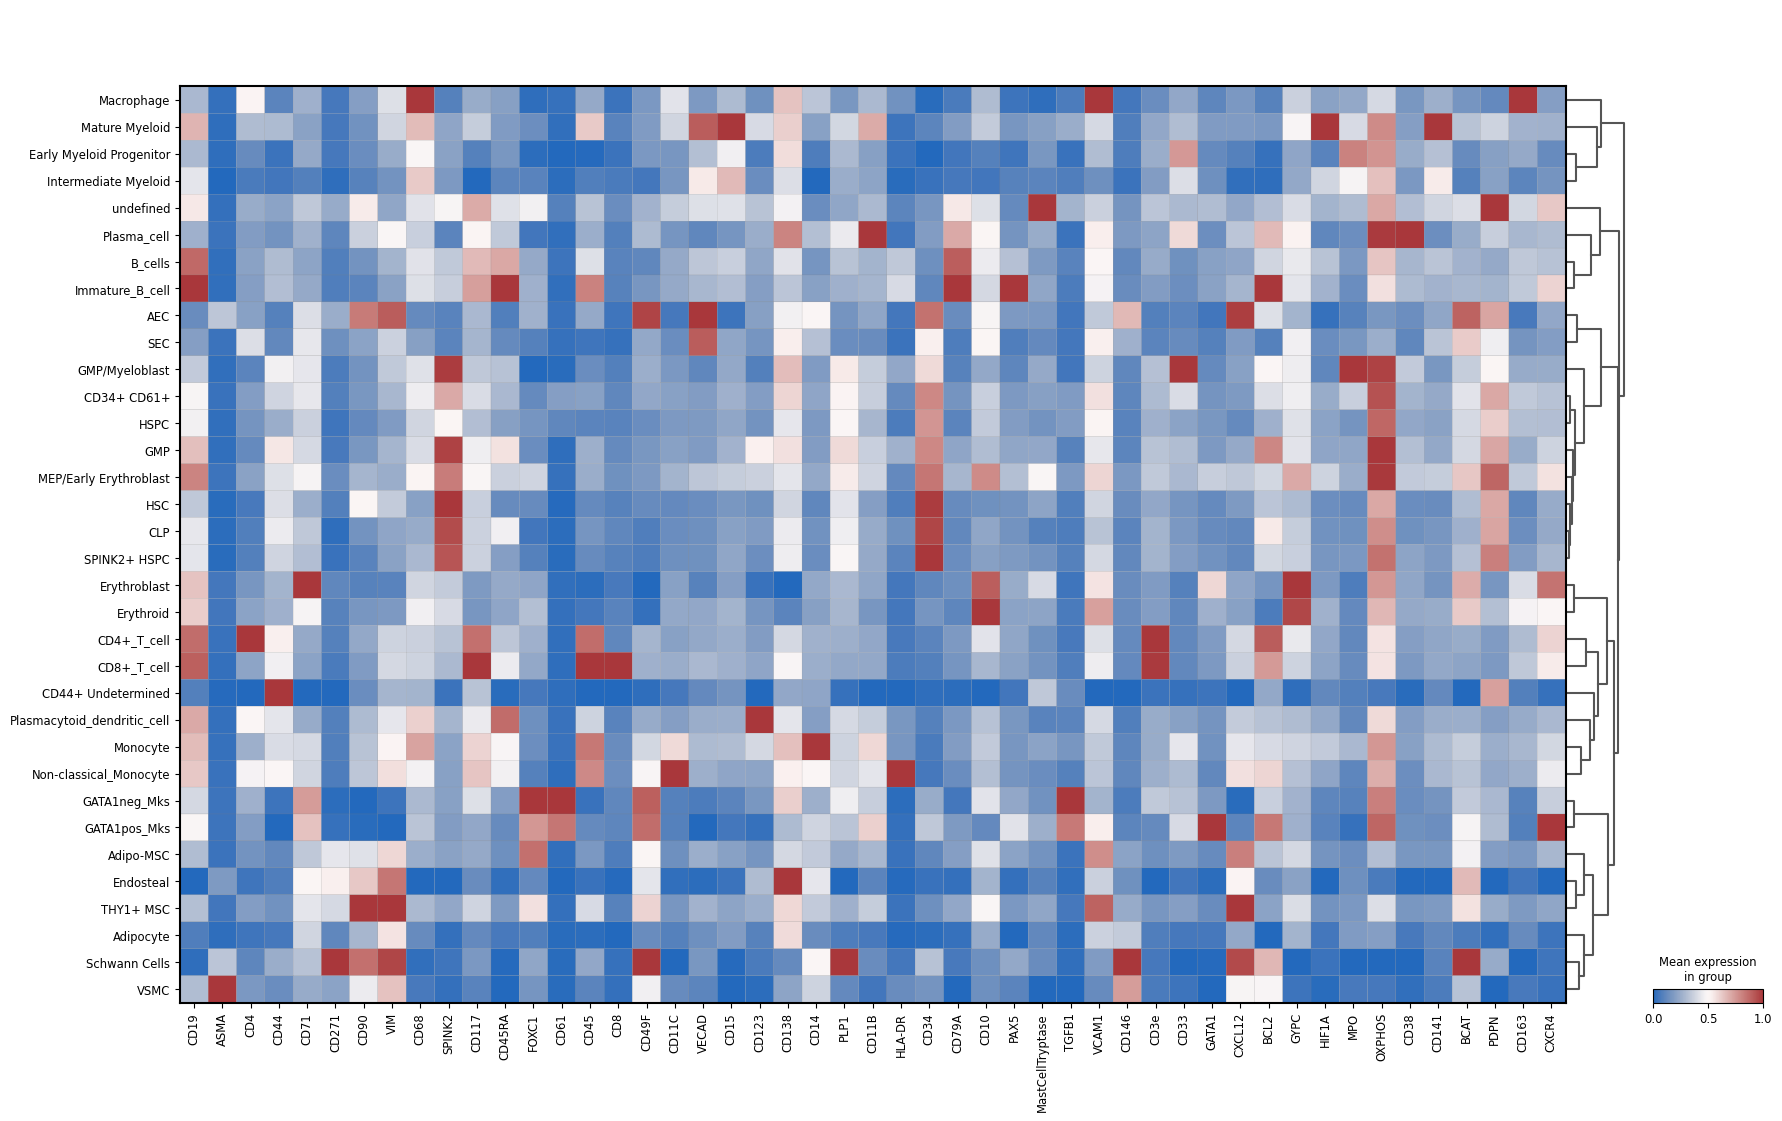

In [11]:
sc.pl.matrixplot(adata, var_names = adata.var_names, groupby='cell_type', cmap='vlag', dendrogram=True, use_raw=False, standard_scale='var')